In [13]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_anomaly_detection

In [14]:
%presentation_style

In [15]:
%%capture

%set_random_seed 12

In [16]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$



# Introduction to Anomaly Detection
<img src="_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">

In [ ]:
import numpy as np


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from tfl_training_anomaly_detection.exercise_tools import evaluate, visualize_mahalanobis

from ipywidgets import interact

from sklearn.metrics import f1_score, precision_score, recall_score

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)


## What is an Anomaly?

<center>
<img src="_static/images/fish.jpg" align="center">
</center>

Grubbs, 1969:
> An outlying observation, or "outlier," is one that appears to deviate markedly from other members of
> the sample in which it occurs.

Hawkins, 1980:
> An outlier is an observation that deviates so much from other observations as to arouse suspicion that it was
> generated by a different mechanism.

Chandola et al., 2009:
>Anomalies are patterns in data that do not conform to a well defined notion of normal behavior

## Anomalies Can be Hard to Detect
<center>
<img src="_static/images/waldo.jpg" align="center" width="800">
</center>

# Practical Relevance of Anomaly Detection

## Predictive Maintenance
- Determine condition of in-service equipment
- Optimize maintenance cycle
- Too frequent inspections cause unnecessary costs and downtime
- Too infrequent inspections can lead to failures or even breaking of the equipment
<center>
<img src="_static/images/failure.jpg" align="center" width="200">
</center>

**Anomaly Detection:** Sensory data can provide valuable information about the condition of the component. Increasingly
abnormal readings may indicate a wear of the equipment.

## Fraud Detection
- Identify fraudulent transactions, e.g. credit card
- Prevent criminal activities
- Avoid financial or other  damages for the involved parties

<center>
<img src="_static/images/fraud.jpg" align="center" width="300">
</center>

**Anomaly Detection:** Fraudulent transactions can often be identified through unusual destinations, amounts,
or network topology (over several transactions).

## Intrusion Detection
- Detect attacks against a network
- Protect nodes against unauthorized access

<center>
<img src="_static/images/cyber.jpg" align="center" width="400">
</center>

**Anomaly Detection**
Malicious connections can leaf unusual footprints, e.g., used protocol, ports, number of packages, IP, duration, etc.

# Relevance of Unsupervised Machine Learning in AD
- Due to the difficulty of identifying anomalies one often has no labeled data available 
- Even if labels are available, anomalies are rare and the data sets are heavily imbalanced  
- Often, we don't want to restrict the system to anomalies that we have encountered in the past
- The information that is available heavily influences the applicable techniques:
    - Is the distribution of nominal data known?
    - Is there clean data (without anomalies) for training?
    - Do we have labeled anomalies for evaluation?
    - How large is the proportion of anomalies?
    - How much noise is in the data?

## Question
Where do you think you can benefit from anomaly detection?
- Which problem do you want to solve?
- How does it translate into an anomaly detection problem?
- What data is available (dimensionality, time dependence, $\ldots$)?
    - Clean data (without anomalies) available?
    - Labeled anomalies available?
    - Proportion of outliers?

# Contamination Framework
<img align="right"  src="_static/images/contamination.png" style="margin: 0px 100px" width="500">

- Unsupervised Scenario
- Two distributions:
    - $F_0$ generates normal points
    - $F_1$ generates anomalies
    - $p$ relative frequency of $F_1$
- Data set $D \stackrel{\text{IID}}{\sim} F=(1-p)F_0 + pF_1$

**Task:** Estimate if a given $x \in D$ is anomalous

**Assumptions:**
- *Few*: $p \ll 1/2$
- *Outlying*: $F_0$ and $F_1$ do not overlap too much
- *Sparse*: $F_1$ is less clustered than $F_0$

## Does the Contamination Framework Always Apply?


No!
- We might have clean data without anomalies available for training
- In an adversarial scenario, like fraud detection, the opponent might change her behavior over time to evade detection
  $\Rightarrow$ $F_1$ might not be well-defined
- The degree to which the three assumptions are true can vary for each specific problem
- Some assumptions might even be false in some scenarios

# Evaluation Metrics
- Accuracy is not a good measure in anomaly detection:
    - $1\%$ anomalies $\Rightarrow$ always predicting nominal gives $99\%$ accuracy!
- Better measures are precision, recall and $F_1$
- The confusion matrix divides a test set according to the predictions and ground truth 

|Confusion Matrix |Actual Nominal| Actual Anomaly|
|---|-----------|-------|
|__Predicted Nominal__ |True Negative (TN)  | False Negative (FN)  |
|__Predicted Anomaly__     |False Positive (FP)| True Positive (TP)|


## Precision, Recall 
- Precision is defined as 

$$\frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}}$$

It estimates the probability that an observation really is anomalous given that the detection system predicted it to be. 
- Recall is defined as 

$$\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}$$

It estimates the probability that an observation will be predicted to be anomalous given that it really is.


## $F_1$ Score
- $F_1$ is defined as the harmonic mean of precision and recall 

$$2\cdot \frac{\text{Precision}\cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$ 

It balances between precision and recall.  

## Evaluating Thresholds
- Most anomaly detection algorithms output an anomaly score where higher values mean more anomalous. 
- We need to set a decision threshold $\tau$ in order to compute precision, recall and $F_1$. 
<img src="_static/images/example_roc_pr.png" width="400" align="right">
- The precision-recall (PR) curve plots the pairs 

$$\{(\text{Recall}(\tau), \text{Precision}(\tau)) \mid \tau_{\text{min}} \leq \tau \leq \tau_{\text{max}}\}$$


- The receiver-operator-characteristics curve (ROC) plots the true positive rate (TPR) against the false positive rate (FPR) for the possible thresholds
    - $\mathrm{TPR(\tau)} = \frac{\mathrm{TP(\tau)}}{\mathrm{TP(\tau)}+\mathrm{FN(\tau)}}$
    - $\mathrm{FPR(\tau)} = \frac{\mathrm{FP(\tau)}}{\mathrm{FP}(\tau)+\mathrm{TN}(\tau)}$

## Cost Matrix
Choosing the optimal threshold does not only depend on the values of our metrics but also on the cost associated to the confusion matrix. Similarly to precision, recall, etc. the confusion matrix has to be understood as a function of the threshold. For each threshold we obtain different numbers of true positives, false positives... . The associated costs e.g. for the false positives are the expected costs that a falsely positive prediction generates (profits are represented as negative costs). Other than the confusion matrix, the cost matrix does not depend on $\tau$. 

|Cost Matrix |Actual Nominal| Actual Anomaly|
|---|---|---|
|__Predicted Nominal__ |Cost of  TN (CTN)| Cost of FN(CFN)|
|__Predicted Anomaly__     |Cost of FP (CFP)|Cost of TP (CTP)|

Our goal is to set the threshold such that the expected empirical costs will be minimized

$$
\begin{align*}
\tau_{\text{opt}}=\arg\min_\tau \frac{\mathrm{TP}(\tau)\cdot \mathrm{CTP} + \mathrm{FP}(\tau)\cdot \mathrm{CFP} + \mathrm{TN}(\tau)\cdot \mathrm{CTN} + \mathrm{FN}(\tau)\cdot \mathrm{CFN}}{N}
\end{align*}
$$

Where $N$ is the total number of samples.

# Our First Anomaly Detection Approach
Let's have a look at a simple probabilistic anomaly score.
- If the distribution of nominal data is known then we can use $-\log p(x)$, also known as the surprise. 
- If only the covariance $\Sigma$ and the mean $\mu$ is known, we can compute the Mahalanobis distance to the mean $\sqrt{(x-\mu)^T\Sigma^{-1}(x-\mu)}$ can be used.
    - Only applicable if nominal distribution is unimodally centered around the mean.
    - Extension for mixture models with means $\mu_1,\ldots,\mu_k$ and covariance matrices  $\Sigma_1,\ldots,\Sigma_k$: $\min_{1\leq i \leq k}\sqrt{(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)}$



## Motivation of Mahalanobis Distance

- The Mahalanobis distance is motivated by the surprise of a Gaussian:
\begin{align*}
-\log p(x) &= -\log \frac{1}{(2\pi)^{\frac{m}{2}}\sqrt{|\det(\Sigma)|}}\exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right)\\ 
&= \frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu) + c
\end{align*}
- Since monotonous transformations (such as $\sqrt{\cdot}$ or adding a constant) don't change the outlier ranking this is equivalent to the Mahalanobis distance


## Exercise
Try the outlier scores for yourself in a simple synthetic scenario. We have prepared the `evaluate` function for you. Try to find the optimal threshold for the dataset.

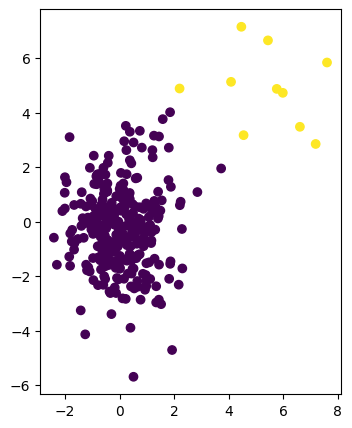

In [ ]:
nominal = np.random.normal(0, [1, 1.5], size=(300, 2))
anomaly = np.random.normal(5, 2, size=(10, 2))

data = np.concatenate([nominal, anomaly], axis=0)
y = np.zeros(310)
y[-10:] = 1

plt.scatter(data[:, 0], data[:,1], c=y)
plt.gca().set_aspect('equal')
plt.show()

**Fit a Gaussian**

In [ ]:
mu = data.mean(axis=0)
Sigma_diag = data.std(axis=0) # assumes independant components
print('Mean: {}\nStd: {}'.format(mu, Sigma_diag))

Mean: [ 0.19830319 -0.08437832]
Std: [1.3811144  1.73864186]


## Question
How did the contamination influence the parameter estimation?

**Compute scores and evaluate**  

In [ ]:
# Mahalanobis distance from the mean of N(mu, Sigma)
scores = np.sqrt(((data - mu) * (1/Sigma_diag) * (data - mu)).sum(axis=1)) 
curves = evaluate(y, scores)

NameError: name 'evaluate' is not defined

**Choose a threshold**

In [ ]:
def visualize_mahalanotis(data, y, scores, mu, sigma_diag, thr):
    _, axes = plt.subplots(figsize=(6, 6))

    # Visualize Data
    scatter_gt = axes.scatter(data[:, 0], data[:,1], c=y)
    plt.scatter(mu[0], mu[1], color='red')
    axes.set_title('Ground Truth')
    handles, _ = scatter_gt.legend_elements()
    axes.legend(handles, ['Nominal', 'Anomaly'])
    axes.set_aspect('equal')
    # Draw descicion contour
    descion_border = Ellipse(
        mu,
        width=2*np.sqrt(sigma_diag[0])*thr,
        height=2*np.sqrt(sigma_diag[1])*thr,
        color='red',
        fill=False
    )
    axes.add_patch(descion_border)
    
    # Evaluate threshold
    y_pred = scores >  thr

    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    axes.set_title("Precision: {}\nRecall: {}\nF1: {}".format(precision, recall, f1))
    
    plt.tight_layout()
    plt.show()


In [ ]:
thr = None

@interact(threshold=(0., 6.))
def set_threshold(threshold):
    global thr
    thr = threshold
    plt.show()

interactive(children=(FloatSlider(value=3.0, description='threshold', max=6.0), Output()), _dom_classes=('widg…

In [ ]:
visualize_mahalanobis(data, y, scores, mu, Sigma_diag, thr)

NameError: name 'visualize_mahalanobis' is not defined

## Task: Find optimal threshold and evaluate on test set.
Choose good threshold. You may write additional code to determine the threshold.

In [ ]:
thr_opt = 3.2 # 

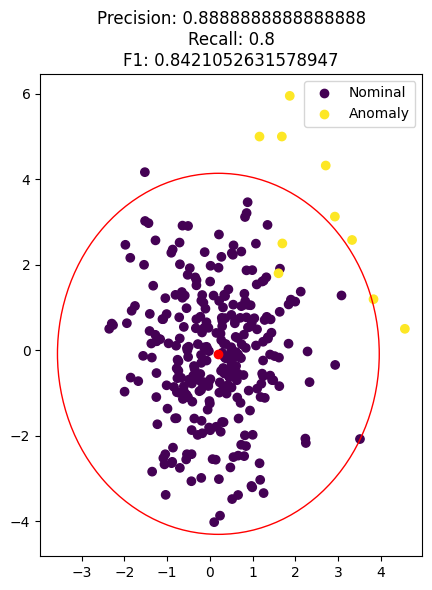

In [ ]:
data_test = np.concatenate([np.random.normal(0, [1, 1.5], size=(300, 2)), np.random.normal(3, 1.5, size=(10, 2))])

y_test = np.zeros(data_test.shape[0])
y_test[-10:] = 1

scores_test = np.sqrt(((data_test - mu) * (1/Sigma_diag) * (data_test - mu)).sum(axis=1)) 

visualize_mahalanotis(data_test, y_test, scores_test, mu, Sigma_diag, thr_opt)

## Summary
- Anomalies are patterns in data that do not conform to a well defined notion of normal behavior.
- Detecting anomalies can be very valuable in a broad spectrum of industry sectors and company divisions.
- Anomaly detection uses mostly unsupervised techniques.
- Outlier scores measure the degree of outlyingness. 
- If some statistical properties of the nominal distribution are known then the surprise or the Mahalanobis distance can be used as an outlier score.
- Evaluation metrics: precision, recall, $F_1$, ROC (AUC), PR (AUC). 



<img src="_static/images/aai-institute-cover.png" alt="Snow"
style="width:100%;">